# Template to analyse time series data

## Summary
In this notebook, we analyze energy data from 9 buildings with a view to creating a prediction model using classic timeseries approaches.

### Data cleaning
The exercise first begins with evaluating and fixing data quality issues because some timeseries analysis tools tend to fail when there are structural inconsistencies in the data. The data was observed to have some systematic errors:

1)Missing data points, these were observed to be missing on the same time stamp across all buildings. Depending on the sensor network architecture it was absurd to have the same error across all building, it could be a pre-processing.

2)Duplicated data points. These were also identified to the same timestamp across all buildings.

3)The descriptive statistics of the data also showed the data sets of the buildings to be very close to each other. Visual inspection indicated general similar structures

### Data Modelling
Modelling the timeseries was conducted to identify suitable a predictive model for energy consumption.
#### ARIMA models
The first idea was to empirically identify a suitable ARIMA model, multiple ARIMA models were fitted and their suitability evaluated. The best identified arima model has ARIMA parameters as follows:

$m2 = sm.tsa.statespace.SARIMAX(data, order=(2,0,1), seasonal_order=(2, 1, 2, 5)).fit()$

However, this model performs poorly on test data, its predictive performance degrades on longer time horizon. Empricially identifying a suitable timeseries models was also hampered by computational challenges. higher orders of the parameters, the simulation used too much memory and there for the search would crash. This happened in both manual implementation and using a library/package.

#### Decomposing timeseries
The timeseries were decomposed to determine the underlying structure. The decomposed series indicated there were multiple levels of seasonality: daily, weekly, yearly. The residuals obtained from this series were normally distributed.

#### Temperature and Energy consumption
Temperature was seen to have negative correlation to energy consumption. Despite a strong negative correlation between temperature and energy consumption, a basic regression model had no relevant predictive power (low $R^{2}$)
A bit of research indicated HDD (Heating Degree Days) could be a more suitable metric which is derived from temperature, although this model was not tested.

Generally, ARIMA type of models were seen to be more promising in predicting the time series. Alternative deep learning approach could also be tested (RNN) for their performance.

In [2]:
# Using a development version of statsmodels(0.14.0), stable release (0.13.2)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pmdarima
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import itertools
import queue
import threading
import multiprocessing
import sys
from time import time, sleep
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.diagnostic import acorr_ljungbox

In [49]:
# Read the raw data
rdata = pd.read_csv('./Granlund_data_anon_040422_v2.csv', sep=';', decimal=',')
#rdata = pd.read_csv('./all_anon_120822_TOSHARE.csv', sep=',', decimal=',') # all_anon_120822_TOSHARE.csv
rdata.head()

,Unnamed: 0,Time,Name,Unit,Year,Month,Day,Hour,Consumption,Temp_outside,Date,Weekday,Holidays,anon_id
0,1,2020-09-14 09:00:00.000,Lämpö,MWh,2020,9,14,9,0.04,9.9,2020-09-14,Monday,0,9
1,2,2019-11-05 19:00:00.000,Lämpö,MWh,2019,11,5,19,0.20,-5.0,2019-11-05,Tuesday,0,9
2,3,2019-03-30 01:00:00.000,Lämpö,MWh,2019,3,30,1,0.05,4.3,2019-03-30,Saturday,0,9
3,4,2019-07-23 16:00:00.000,Lämpö,MWh,2019,7,23,16,0.01,24.2,2019-07-23,Tuesday,0,9
4,5,2019-12-03 15:00:00.000,Lämpö,MWh,2019,12,3,15,0.19,-2.0,2019-12-03,Tuesday,0,9


In [50]:
# Set the index and check if the data types are intuitive
data = rdata.set_index('Time')
data.dtypes

Unnamed: 0        int64
Name             object
Unit             object
Year              int64
Month             int64
Day               int64
Hour              int64
Consumption     float64
Temp_outside    float64
Date             object
Weekday          object
Holidays          int64
anon_id           int64
dtype: object

In [51]:
# Get overview of other data columns
for col in data.columns:
    if col in ['Consumption', 'Temp_outside', 'Date', 'Weekday', 'Unnamed: 0']:
        continue
    print(f'{col}: {data[col].unique()}')

Name: ['Lämpö']
Unit: ['MWh']
Year: [2020 2019 2021 2022]
Month: [ 9 11  3  7 12  8  6  1  2  5  4 10]
Day: [14  5 30 23  3  9  4 29  1 11 12 13 19 17 24  8 18 28 15 31 22 10  2 25
  6 21  7 26 27 20 16]
Hour: [ 9 19  1 16 15 23 14 18 17  3  0  5 10 20  2 22  8  7 21  6  4 13 12 11]
Holidays: [0 1]
anon_id: [ 9 11  1  4  7 10 12  6  8]


In [79]:
# Pick only relevant columns
# Convert the index to a datetime object type and sort it
data = data[['Consumption', 'Temp_outside', 'anon_id']]
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.head()

,Consumption,Temp_outside,anon_id
Time,,,
2019-01-01 02:00:00,0.30,0.7,10
2019-01-01 02:00:00,0.11,0.7,7
2019-01-01 02:00:00,0.06,0.7,6
2019-01-01 02:00:00,0.07,0.7,9
2019-01-01 02:00:00,0.60,0.7,4


In [53]:
# Generate independent masks for extracting a building's tseries, store the masks as an object of the form:
# {anon_id: tseries_mask, anon_id: tseries_mask}
masks = dict()
for unique_id in data['anon_id'].unique():
    masks[unique_id] = data['anon_id']==unique_id

In [70]:
# Sample mask usage
print(f'available buildings: {list(masks.keys())}')

# Get all data for building 10
# plt.plot(data[masks[10]][['Consumption', 'Temp_outside']])
data[masks[10]]

available buildings: [10, 7, 6, 9, 4, 8, 11, 1, 12]


,Consumption,Temp_outside,anon_id
Time,,,
2019-01-01 02:00:00,0.3,0.7,10
2019-01-01 03:00:00,0.3,0.8,10
2019-01-01 04:00:00,0.3,0.8,10
2019-01-01 05:00:00,0.3,0.9,10
2019-01-01 06:00:00,0.3,1.1,10
...,...,...,...
2022-03-31 20:00:00,0.3,-1.0,10
2022-03-31 21:00:00,0.4,-1.8,10
2022-03-31 22:00:00,0.3,-3.0,10


In [80]:
print(f' Number of buildings {len(masks.keys())}')

for k in masks.keys():
    print(f'building id: {k}')
    print(data[masks[k]].describe())

 Number of buildings 9
building id: 10
        Consumption  Temp_outside  anon_id
count  28462.000000  28444.000000  28462.0
mean       0.229554      5.563469     10.0
std        0.199213      9.351405      0.0
min        0.000000    -26.000000     10.0
25%        0.000000     -0.300000     10.0
50%        0.200000      4.300000     10.0
75%        0.400000     12.500000     10.0
max        1.100000     32.800000     10.0
building id: 7
        Consumption  Temp_outside  anon_id
count  28462.000000  28444.000000  28462.0
mean       0.095404      5.563469      7.0
std        0.085151      9.351405      0.0
min        0.000000    -26.000000      7.0
25%        0.010000     -0.300000      7.0
50%        0.090000      4.300000      7.0
75%        0.140000     12.500000      7.0
max        0.490000     32.800000      7.0
building id: 6
        Consumption  Temp_outside  anon_id
count  28462.000000  28444.000000  28462.0
mean       0.049674      5.563469      6.0
std        0.037210      9.3

### Visual inspection

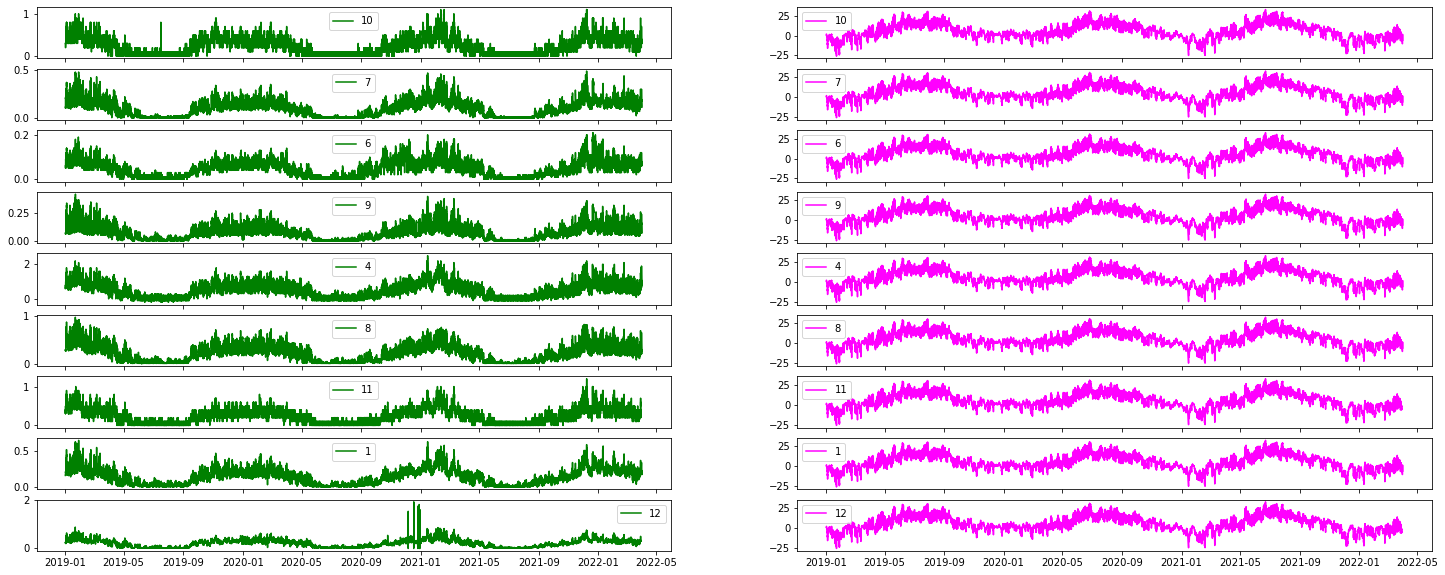

In [9]:
# Extract all independent series and plot their values for visual inspection
# Notable seasonality in both energy and temp data

fig, ax = plt.subplots(9, 2, figsize=(25, 10), sharex=True)

for row, anon_id  in enumerate(masks.keys()):
        ax[row][0].plot(data[masks[anon_id]]['Consumption'], color='green', label=anon_id)
        ax[row][1].plot(data[masks[anon_id]]['Temp_outside'], color='magenta', label=anon_id)
        ax[row][0].legend()
        ax[row][1].legend()

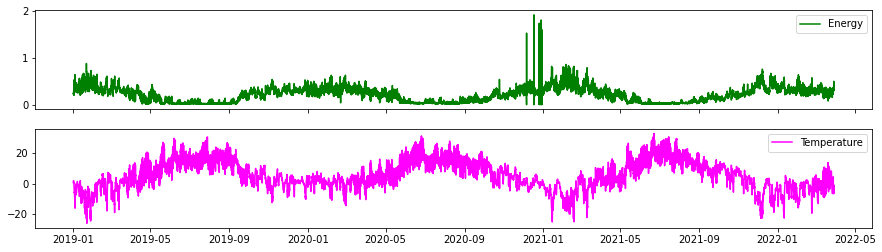

In [10]:
# Example of potential outliers in building 12 dataset

fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True)
_ = ax[0].plot(data[masks[12]]['Consumption'], color='green', label='Energy')
_ = ax[1].plot(data[masks[12]]['Temp_outside'], color='magenta', label='Temperature')

for i in range(len(ax)): ax[i].legend()

No of observations: [28462, 28462, 28462, 28462, 28462, 28462, 28419, 28462, 28419]


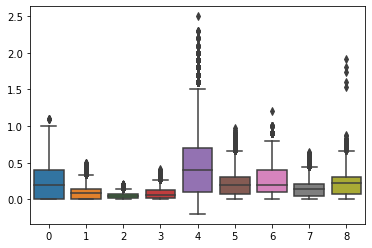

In [11]:
# Energy consumption distributions across buildings
# The box plots below indicate the data have slightly different distributions
energy_consumption_data = [data[masks[k]]['Consumption'].values for k in masks.keys()]
print(f'No of observations: {[len(energy) for energy in energy_consumption_data]}')
_ = sns.boxplot(data=energy_consumption_data)

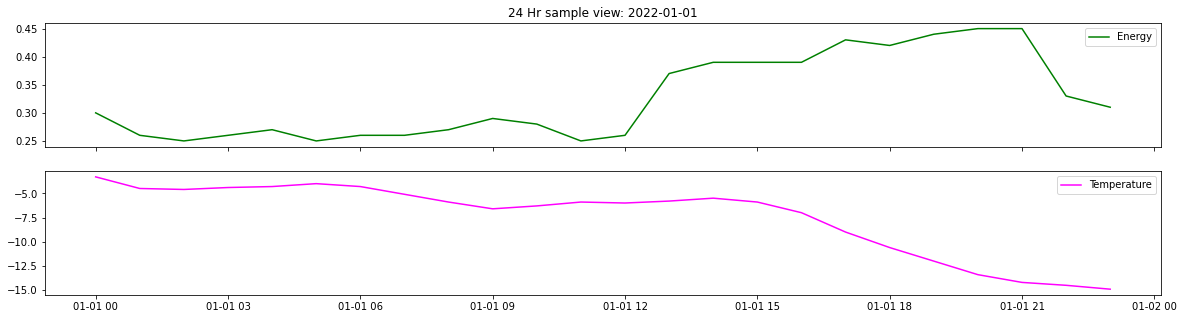

In [12]:
# 24 Hr sample view
fig, ax = plt.subplots(2, 1, figsize=(20, 5), sharex=True)
_ = ax[0].plot(data[masks[12]]['Consumption'].loc['2022-01-01'], color='green', label='Energy')
_ = ax[1].plot(data[masks[12]]['Temp_outside'].loc['2022-01-01'], color='magenta', label='Temperature')
ax[0].set_title('24 Hr sample view: 2022-01-01')
for i in range(len(ax)): ax[i].legend()

### Check for duplicates in the timeseries index

In [81]:
# Check for duplicate timestamp entries
for k in masks.keys():
    print(f'building {k} has duplicates: {data[masks[k]].index.has_duplicates}',
          f'{sum(data[masks[k]].index.duplicated())} duplicates')

building 10 has duplicates: True 3 duplicates
building 7 has duplicates: True 3 duplicates
building 6 has duplicates: True 3 duplicates
building 9 has duplicates: True 3 duplicates
building 4 has duplicates: True 3 duplicates
building 8 has duplicates: True 3 duplicates
building 11 has duplicates: True 3 duplicates
building 1 has duplicates: True 3 duplicates
building 12 has duplicates: True 3 duplicates


In [14]:
# How does the same time stamp get duplicated across all buildings? across all years ?
# Could this be a bug in the data recording system? or was the data synthetically created (i.e duplicated)

for k in masks.keys():
    duplicate_mask = data[masks[k]].index.duplicated()
    print(data[masks[k]][duplicate_mask])

                     Consumption  Temp_outside  anon_id
Time                                                   
2019-10-27 03:00:00          0.4           3.3       10
2020-10-25 03:00:00          0.2          -2.6       10
2021-10-31 03:00:00          0.1           8.0       10
                     Consumption  Temp_outside  anon_id
Time                                                   
2019-10-27 03:00:00         0.08           3.3        7
2020-10-25 03:00:00         0.09          -2.0        7
2021-10-31 03:00:00         0.05           8.0        7
                     Consumption  Temp_outside  anon_id
Time                                                   
2019-10-27 03:00:00         0.05           3.3        6
2020-10-25 03:00:00         0.09          -2.0        6
2021-10-31 03:00:00         0.03           8.1        6
                     Consumption  Temp_outside  anon_id
Time                                                   
2019-10-27 03:00:00         0.05           4.0  

In [15]:
# How does the duplicate look in the actual data across the years for one of the buildings (ID: 10)
print(data[masks[10]].loc['2019-10-27'][2:6])
print(data[masks[10]].loc['2020-10-25'][2:6])
print(data[masks[10]].loc['2021-10-31'][2:6])
print(data[masks[10]].loc['2021-10-31'][2:6])

                     Consumption  Temp_outside  anon_id
Time                                                   
2019-10-27 02:00:00          0.4           4.0       10
2019-10-27 03:00:00          0.4           4.0       10
2019-10-27 03:00:00          0.4           3.3       10
2019-10-27 04:00:00          0.4           3.7       10
                     Consumption  Temp_outside  anon_id
Time                                                   
2020-10-25 02:00:00          0.3          -1.4       10
2020-10-25 03:00:00          0.2          -2.0       10
2020-10-25 03:00:00          0.2          -2.6       10
2020-10-25 04:00:00          0.3          -3.0       10
                     Consumption  Temp_outside  anon_id
Time                                                   
2021-10-31 02:00:00          0.1           7.9       10
2021-10-31 03:00:00          0.1           8.1       10
2021-10-31 03:00:00          0.1           8.0       10
2021-10-31 04:00:00          0.1           8.1  

In [16]:
# Testing Removing duplicates
# print(f'Has duplicates: {data[masks[10]][~data[masks[10]].index.duplicated()].index.has_duplicates}')
data[masks[10]][~data[masks[10]].index.duplicated()].loc['2019-10-27'][2:6]

,Consumption,Temp_outside,anon_id
Time,,,
2019-10-27 02:00:00,0.4,4.0,10
2019-10-27 03:00:00,0.4,4.0,10
2019-10-27 04:00:00,0.4,3.7,10
2019-10-27 05:00:00,0.4,3.4,10


## Fixing missing indices
For time series analysis, the freq attribute of a timeseries index is required for timestamp based prediction. Any incosistencies in the timeseries index leads to the attribute freq=None

In [82]:
# Create a reference timeseries based on the start and end timestamps and the expected freq
# Looking for missing time indices
# All buildings seem to be missing entries on the same timestamp ??
for k in masks.keys():
    original_index = data[masks[k]][~data[masks[k]].index.duplicated()].index
    start_date = original_index[0]
    end_date = original_index[-1]
    reference_index = pd.date_range(start=start_date, end=end_date, freq='H')
    #original_index = data[masks[k]][~data[masks[k]].index.duplicated()].index
    print(f'Building {k} missing {len(set(reference_index).difference(set(original_index)))} entries')
    print(pd.to_datetime(list(set(reference_index).difference(data[masks[10]].index))))



Building 10 missing 4 entries
DatetimeIndex(['2021-03-28 03:00:00', '2022-03-27 03:00:00',
               '2019-03-31 03:00:00', '2020-03-29 03:00:00'],
              dtype='datetime64[ns]', freq=None)
Building 7 missing 4 entries
DatetimeIndex(['2021-03-28 03:00:00', '2022-03-27 03:00:00',
               '2019-03-31 03:00:00', '2020-03-29 03:00:00'],
              dtype='datetime64[ns]', freq=None)
Building 6 missing 4 entries
DatetimeIndex(['2021-03-28 03:00:00', '2022-03-27 03:00:00',
               '2019-03-31 03:00:00', '2020-03-29 03:00:00'],
              dtype='datetime64[ns]', freq=None)
Building 9 missing 4 entries
DatetimeIndex(['2021-03-28 03:00:00', '2022-03-27 03:00:00',
               '2019-03-31 03:00:00', '2020-03-29 03:00:00'],
              dtype='datetime64[ns]', freq=None)
Building 4 missing 4 entries
DatetimeIndex(['2021-03-28 03:00:00', '2022-03-27 03:00:00',
               '2019-03-31 03:00:00', '2020-03-29 03:00:00'],
              dtype='datetime64[ns]', freq=

In [83]:
# Create a new index and reassign the timeseries

df = data[masks[10]][~data[masks[10]].index.duplicated()]
start_date = df.index[0]
end_date = df.index[-1]
new_index = pd.date_range(start=start_date, end=end_date, freq='H')
print(f'new index length: {len(new_index)}, old index length {len(data[masks[10]].index)}')
new_df = pd.DataFrame(index=new_index)   
new_df['Consumption_10'] = df['Consumption']
new_df['Temp_outside_10'] = df['Temp_outside']

new index length: 28463, old index length 28462


New timestamps get assigned NaN values across all features. To fill these NaN values, interpolation is a good solution (df.interpolate(method='slinear') and there are a variety of interpolation methods indicated in the documentation.

Alternatively, NaN entries can be dropped (df.dropna()) but that is not a good solution in this case it destroys the timeseries sequence once again due to the resulting gaps in the index which will cause the freq attribute to get a None value.

In [19]:
# NaN entries
new_df.loc['2019-03-31'][:5]

,Consumption_10,Temp_outside_10
2019-03-31 00:00:00,0.3,2.7
2019-03-31 01:00:00,0.2,2.4
2019-03-31 02:00:00,0.1,2.2
2019-03-31 03:00:00,NaN,NaN
2019-03-31 04:00:00,0.3,2.0


Despite some missing values (NaNs), now the series has a proper freq attribute (freq='H') indicating the Hourly frequency of the timeseries


In [20]:
new_df.index

DatetimeIndex(['2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00',
               '2019-01-01 08:00:00', '2019-01-01 09:00:00',
               '2019-01-01 10:00:00', '2019-01-01 11:00:00',
               ...
               '2022-03-31 15:00:00', '2022-03-31 16:00:00',
               '2022-03-31 17:00:00', '2022-03-31 18:00:00',
               '2022-03-31 19:00:00', '2022-03-31 20:00:00',
               '2022-03-31 21:00:00', '2022-03-31 22:00:00',
               '2022-03-31 23:00:00', '2022-04-01 00:00:00'],
              dtype='datetime64[ns]', length=28463, freq='H')

In [21]:
# Fill in missing values through interpolation
# There are different interpolation methods
new_df.interpolate(method='slinear', inplace=True)
new_df.loc['2019-03-31'][:5]

,Consumption_10,Temp_outside_10
2019-03-31 00:00:00,0.3,2.7
2019-03-31 01:00:00,0.2,2.4
2019-03-31 02:00:00,0.1,2.2
2019-03-31 03:00:00,0.2,2.1
2019-03-31 04:00:00,0.3,2.0


In [22]:
# new index preserves the correct index attributes especially the freq which causes failure in
# statsmodels timeseries modelling libraries
new_df.index

DatetimeIndex(['2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00',
               '2019-01-01 08:00:00', '2019-01-01 09:00:00',
               '2019-01-01 10:00:00', '2019-01-01 11:00:00',
               ...
               '2022-03-31 15:00:00', '2022-03-31 16:00:00',
               '2022-03-31 17:00:00', '2022-03-31 18:00:00',
               '2022-03-31 19:00:00', '2022-03-31 20:00:00',
               '2022-03-31 21:00:00', '2022-03-31 22:00:00',
               '2022-03-31 23:00:00', '2022-04-01 00:00:00'],
              dtype='datetime64[ns]', length=28463, freq='H')

## Fix entire dataset

In [84]:
# Fix the dataset based on the identified issues and solutions
# create a clean dataset and collect them in an object
# One more issue was identified in some later cells below (0 values of energy consumption)
# when taking the log(0) a division by zero runtime warning is generated
# A look into the data looks like the zero is actually an errenous entry since it happens on a specific timestamp
# across the data.
clean_data = {}
for k in masks.keys():
    print(f'building {k} has {sum(data[masks[k]].index.duplicated())} duplicates')
    original_index = data[masks[k]][~data[masks[k]].index.duplicated()].index # remove duplicates
    start_date = original_index[0]
    end_date = original_index[-1]
    new_index = pd.date_range(start=start_date, end=end_date, freq='H') # create a new reference index
    print(f'Building {k} missing {len(set(reference_index).difference(set(original_index)))} index entries')
    new_df = pd.DataFrame(index=new_index)   
    new_df['Consumption'] = df['Consumption']
    new_df['Temp_outside'] = df['Temp_outside']
    new_df.interpolate(method='slinear', inplace=True) # Handle NaNs with interpolation
    clean_data[k] = new_df

building 10 has 3 duplicates
Building 10 missing 4 index entries
building 7 has 3 duplicates
Building 7 missing 4 index entries
building 6 has 3 duplicates
Building 6 missing 4 index entries
building 9 has 3 duplicates
Building 9 missing 4 index entries
building 4 has 3 duplicates
Building 4 missing 4 index entries
building 8 has 3 duplicates
Building 8 missing 4 index entries
building 11 has 3 duplicates
Building 11 missing 4 index entries
building 1 has 3 duplicates
Building 1 missing 4 index entries
building 12 has 3 duplicates
Building 12 missing 4 index entries


In [24]:
# copy files from local machine to remote folder
# !scp Granlund_data_anon_040422_v2.csv ubuntu@128.214.x.x/home/ubuntu/ 

# Time series Analysis
This section is based on two approaches, ARIMA models and Regression models

In [26]:
# Single thread version of ARIMA model simulations
# The function seasonal_arima_simulation() is a compute intensive function
y_t = 
def seasonal_arima_simulation(data, start_date='2022-01-01 00:00:00', **kwargs):
    """
    Runs tests to identify suitable model parameters for a seasonal
    arima model by printing out the AIC values, over multiple
    variations of a model, the model with the lowest AIC value is
    considered to be the most optimal model.

    In order to create a forecasting seasonal ARIMA model, we need to
    select the most optimum model which is based on picking the model
    with the the lowest AIC value

    data: the data to be analysed
    start_date: the begin of testing a prediction model

    Returns a dataframe with all tested models and their AIC, BIC and
    prediction results values. The dataframe is sorted based in AIC

    TODO: There is an opportunity to optimise this function to include
    multithreading ability to speed up testing of the models but it might be that the underlying libraries
    already parallelize the computations?
    """
    from warnings import filterwarnings
    filterwarnings("ignore")
    resultQueue = queue.Queue()
    start = time()
    
    # Generate combinations of various (p, d, q) parameters to simulate
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    pdq_seasonal = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    def test_model(params, seasonal_params):
        """ 
        Test a single model instance and put the results in a Queue, could also be a simple list
        """
        model = sm.tsa.statespace.SARIMAX(data, order=params, seasonal_order=seasonal_params, 
                                          enforce_stationarity=False, enforce_invertibility=False, trend=None)
        res = model.fit()
        pred = res.get_prediction(start=start_date)
        pred_values = pred.predicted_mean
        mae = mean_absolute_error(data[start_date:], pred_values)
        mse = mean_squared_error(data[start_date:], pred_values)
        rmse = np.sqrt(mse)
        resultQueue.put((params, seasonal_params, res.aic, res.bic, mae, mse, rmse))
    
    for orderARIMA in pdq:
        for seasonalARIMA in pdq_seasonal:
            test_model(orderARIMA, seasonalARIMA)

    end = time() - start
    print(f'Simulation took {end}')

    # After running the simulations, package the results in a dataframe
    df = pd.DataFrame([resultQueue.get() for i in range(resultQueue.qsize())],
                      columns=['ARMA Order', 'Seasonal Order', 'AIC', 'BIC', 'MAE', 'MSE', 'RMSE'])
    df.sort_values('AIC', inplace=True)
    return df

def model_sarimax(data, arima_pdq, seasonal_pdq, invertibility=False, stationarity=False, **kwargs):
    """
    Fits a seasonal ARIMA model

    data: Series to be used in the model
    arima_pdq: iterable (p, d, q) parameters for the ARIMA component
    seasonal_pdq: iterable (P, D, Q, s) parameters for the seasonal component

    Returns a fitted model object.
    """
    model = sm.tsa.statespace.SARIMAX(data, order=arima_pdq, seasonal_order=seasonal_pdq,
                                      enforce_invertibility=invertibility,
                                      enforce_stationarity=stationarity, **kwargs)
    return model.fit()

def print_results_sarimax(model_results, simple_results=True):
    """
    Prints results from an already fitted model

    simple_results: flag to control the amount of information printed,
    when the comprehensive results are printed, more information is
    printed that is useful in determining how well the model has been
    fit, particularly Ljung-Box and Jarque-Bera tests.
    """
    if simple_results:
        print("{}".format(model_results.summary().tables[1]))
    else:
        print("{}".format(model_results.summary()))


In [1]:
# Parallelised version

# CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
# Simulation took 1231.7924981117249
# simulation took 61.445193056265516 mins
# Before parallelization simulating 3 buildings takes 61 mins
# After parallelization, simulating 3 buildings takes 14.23.mins

# The data can be split into Training and Test sets although in this case all data is used to fit the model
# train = clean_data[k]['Consumption'].loc[:'2021'] # use all data until 2021 as a training set
# test = clean_data[k]['Consumption'].loc['2022':] # all 2022 data as training set

resultQueue = multiprocessing.Queue()
processes = list()

def test_model(data, building_id,  params, seasonal_params, result_queue):
    """ 
    Test a single model instance and put the results in a Queue.
    
    A queue provides in built synchronization
    """
    model = sm.tsa.statespace.SARIMAX(data, order=params, seasonal_order=seasonal_params, 
                                      enforce_stationarity=False, enforce_invertibility=False, trend=None)
    res = model.fit()
    pred = res.get_prediction(start=start_date)
    pred_values = pred.predicted_mean
    mae = mean_absolute_error(data[start_date:], pred_values)
    mse = mean_squared_error(data[start_date:], pred_values)
    rmse = np.sqrt(mse)
    result_queue.put([building_id, params, seasonal_params, res.aic, res.bic, mae, mse, rmse])

def seasonal_arima_simulation_threaded(data, building_id, start_date='2022-01-01 00:00:00', **kwargs):
    """
    Perform simulation on a multicore environment in a manner that 
    bypasses Python's  Global Interpreter Lock (GIL)
    
    Significant performance gains observered 4X reduction in time (61.45mins to 14.23mins) 
    Tested by simulating 3 buildings in single and multi-processor code
    """
    from warnings import filterwarnings
    filterwarnings("ignore")

    # Generate combinations of various (p, d, q) parameters to simulate
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    pdq_seasonal = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    #print(f'simulating a total of {len(pdq) * len(pdq_seasonal) * len(masks.keys())} models')
    start = time()
    for orderARIMA in pdq:
        for seasonalARIMA in pdq_seasonal:
            try:
                p = multiprocessing.Process(target=test_model, args=(data, building_id, orderARIMA, seasonalARIMA, resultQueue)) # spawn processes to make use of multi-processor context
                processes.append(p)
                #processesQueue.put(p)
                p.start()
            except:
                print("An error occurred: ", sys.exc_info()[0])
    for process in processes:
        process.join()
    print(f'took {time() - start} to complete simulating building {building_id}')
    df = pd.DataFrame([resultQueue.get() for i in range(resultQueue.qsize())], columns=['building_id', 'ARMA Order', 'Seasonal Order', 'AIC', 'BIC', 'MAE', 'MSE', 'RMSE']) 
    df.sort_values('AIC', inplace=True)
    return df

simulation_res_df = pd.DataFrame(columns=masks.keys())

start = time()
for i, k in enumerate(masks.keys()):
    print(f'Simulating model for Building {k}')
    sim_res = seasonal_arima_simulation_threaded(clean_data[k]['Consumption'], k, start_date='2022-01-01 00:00:00')
    print(f'recording results')
    simulation_res_df[k] = sim_res.iloc[0] # For each building, store the best model
print(f'>>> simulation for all buildings took {(time()- start)} secs')

NameError: name 'multiprocessing' is not defined

In [ ]:
# Best parameters for each building
# All building models have similar parameters ??

simulation_res_df

## Fit models for all buildings
After the simulations, we fit the best models for each building. In this case, the building ARIMA model's have similar parameters as shown in the table above (simulations_res_df)

In [30]:
# Since the best performing model in each building have similar parameters (based on the data) 
# we can easily fit just one ARIMA model and use it across all buildings
# Parameters: ARMA = (1, 1, 1) Seasonal Order = (1, 0, 1, 12)

modelQueue = multiprocessing.Queue()
modelProcesses = list()

res = model.fit()
pred = res.get_prediction(start=start_date)
pred_values = pred.predicted_mean
mae = mean_absolute_error(data[start_date:], pred_values)
mse = mean_squared_error(data[start_date:], pred_values)
rmse = np.sqrt(mse)
result_queue.put([building_id, params, seasonal_params, res.aic, res.bic, mae, mse, rmse])



def fitmodel(model_id, model_queue, data):
    """
    Fit a single model
    
    Storing the model.fit() object in the queue fails, needs to store simpler objects e.g ints
    """
    model = sm.tsa.statespace.SARIMAX(data, order=(1,1,1), seasonal_order=(1, 0, 1, 12),
                                      enforce_invertibility=False,
                                      enforce_stationarity=False)
    res = model.fit()
    res.get_prediction(start='2021-01-01 00:00:00')
    model_queue.put([model_id, res.mae]) 

def fitmodels():
    """
    Fit all the models
    """
    start_time = time()
    for k in masks.keys():
        print(f'training model {k}')
        train_y = clean_data[k]['Consumption'][:'2021']
        p = multiprocessing.Process(target=fitmodel, args=(k, modelQueue, train_y))
        modelProcesses.append(p)
        p.start()
    for proc in modelProcesses:
        print(f'waiting process {proc} to join')
        proc.join()
        print(f'process {proc} completed')
    print(f'Fitting all models took {time() - start_time}')

fitmodels()

NameError: name 'model' is not defined

In [27]:
# Testing the paramaters in one room
# training set 2019-2021 data
# test set 2022 data
model12res = sm.tsa.statespace.SARIMAX(clean_data[12]['Consumption'][:'2021'],
                                       order=(1,1,1), seasonal_order=(1, 0, 1, 12),
                                       enforce_invertibility=False,
                                       enforce_stationarity=False)
res = model12res.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27467D+00    |proj g|=  1.22071D-01


 This problem is unconstrained.



At iterate    5    f= -1.28081D+00    |proj g|=  1.16083D-01

At iterate   10    f= -1.28133D+00    |proj g|=  3.12781D-02

At iterate   15    f= -1.28188D+00    |proj g|=  4.38243D-01

At iterate   20    f= -1.34620D+00    |proj g|=  1.14186D+00

At iterate   25    f= -1.35615D+00    |proj g|=  2.36713D-02

At iterate   30    f= -1.35659D+00    |proj g|=  9.97986D-02

At iterate   35    f= -1.35722D+00    |proj g|=  1.87327D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     60      1     0     0   8.640D-06  -1.357D+00
  F =  -1.3572239102152859     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

In [28]:
# One approach to check if our model fits the data, test if the residuals are normally distrubuted or random noise
# Any form of structure in the the residuals suggests the model does not still fully fit the data
# We can use statistical tests: Ljungbox and Box-pierce tests, H_o: The data are independently distributed

# The results indicate we would reject the hypothesis that the residuals are random noise
acorr_ljungbox(res.resid, lags=12, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.463352,4.960616e-01,0.463299,4.960861e-01
2,1.821428,4.022368e-01,1.821169,4.022890e-01
3,49.350107,1.098732e-10,49.340813,1.103749e-10
4,51.809969,1.511614e-10,51.800114,1.518803e-10
5,57.299419,4.386993e-11,57.288103,4.410622e-11
6,73.967711,6.260149e-14,73.951325,6.308927e-14
7,148.854393,7.064259e-29,148.812385,7.209186e-29
8,216.499433,2.113318e-42,216.431709,2.184074e-42
9,247.364812,3.590960e-48,247.284180,3.734462e-48
10,295.542744,1.360485e-57,295.440132,1.430132e-57


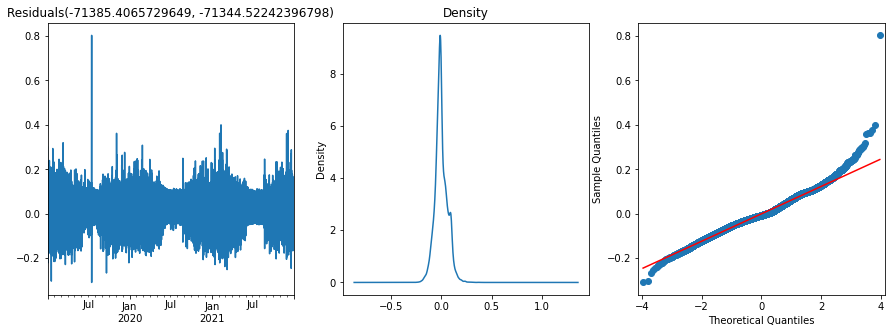

In [29]:
# When we plot the residuals of the fitted model, it is evident the residuals have a descernable structure
# The QQ-plot (3rd plot) also shows some outliers in the upper and lower parts of the line

# Consistent with the statistical tests (Ljungbox and Box-Pierce), the residual plot shows that there is still some
# structure in the residuals (y_true - y_hat) meaning the model does not fully represent the data
# the structure of the underlying timeseries
fig, ax = plt.subplots(1,3, figsize=(15, 5))
res.resid.plot(title=f"Residuals{res.aic, res.bic}", ax=ax[0])
res.resid.plot(kind='kde', title='Density', ax=ax[1])
_ = sm.qqplot(res.resid, line='r', ax=ax[2])
plt.show()

## pmdarima

Spent some time implementing the timeseries empirical model search manually (above) but learnt there is a library (pdmarima) which provides this exact functionality. One good thing about the library, it seems to automatically optimize the search using the underlying HW right away. These cell below was ran on a multicore instance and the search was able to utilize all cores in the instance without any added configuration see image below.
https://pypi.org/project/pmdarima/



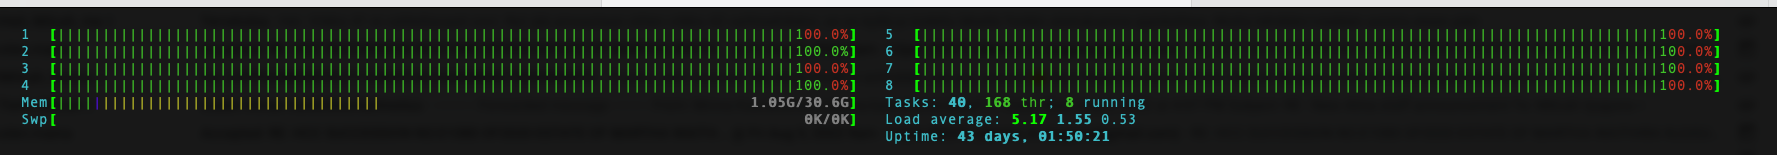

In [30]:
# pdmarima package can utilize a multicore instance automatically
from IPython.display import Image
Image(filename='pdmarima_hw_optimization.png') 

In [33]:
# The results of this search are different from my earlier search but the bounding parameters in my manual search 
# were different. This search does not find any seasonal parameters but it extends the search on 
# the order of the arima (p,d,q) parameters of the model

# The results suggest Autoregressive order (p) 5 (consistent with weekdays), difference (d) 1 time and order of the 
# moving average (q) 0

empirical_model = pmdarima.auto_arima(clean_data[12]['Consumption'][:'2021'],
                                      start_p=1, start_q=1, trace=True,
                                      max_p=7, max_d = 7, max_q=7,
                                      max_P=12, max_D = 6, max_Q=12,
                                      seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-66992.632, Time=9.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-57112.920, Time=3.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-65882.814, Time=2.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-66137.802, Time=11.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-57114.920, Time=1.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-67070.238, Time=22.90 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67048.086, Time=2.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-67081.451, Time=50.96 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-67075.821, Time=4.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-67084.918, Time=17.26 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-67085.510, Time=4.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-67085.705, Time=19.31 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-67084.467, Time=31.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-67082.919, Time=56.76 se

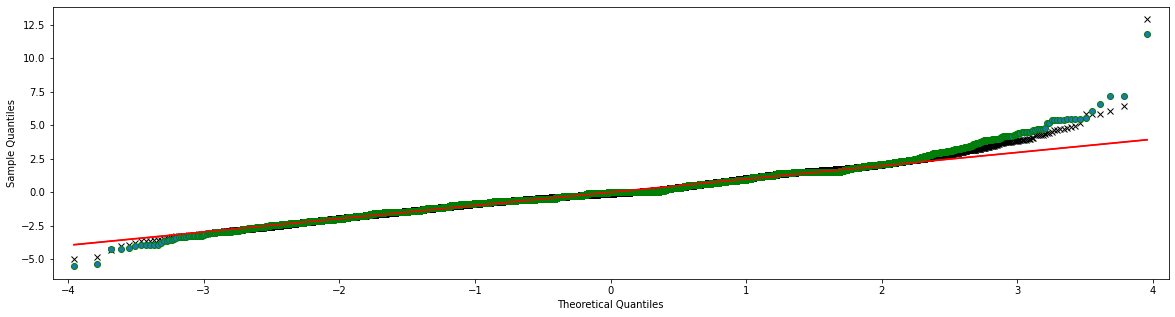

In [34]:
# QQ plots show heavy tails on the data
fig, ax = plt.subplots(figsize=(20, 5))
_ = sm.qqplot(res.resid, line='r', ax=ax, fit=True, marker='x', markeredgecolor='k')
_ = sm.qqplot(empirical_model.resid(), line='r', ax=ax, fit=True, markeredgecolor='g')
plt.show()

In [44]:
# Fitting one of the suggested best models
# model with parameters:  ARIMA(5,1,0)(0,0,0)[0]   
m1 = sm.tsa.statespace.SARIMAX(clean_data[12]['Consumption'][:'2021'],order=(5,1,0)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27556D+00    |proj g|=  5.00151D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     13      1     0     0   2.978D-04  -1.276D+00
  F =  -1.2755627906034510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


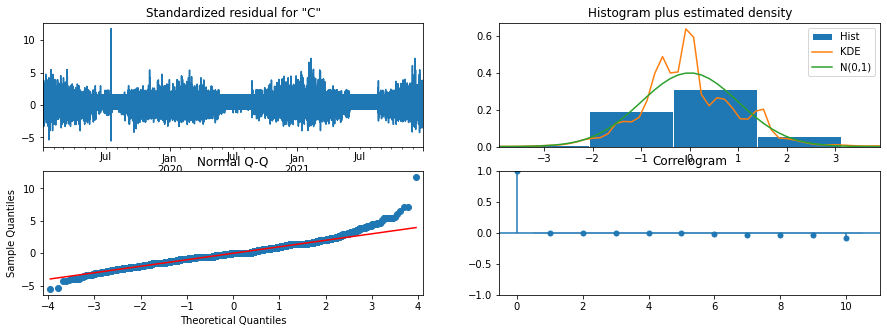

In [45]:
# Plot diagnostics of model m1
_ = m1.plot_diagnostics(figsize=(15, 5))

In [46]:
# Checking the summary of the m1
# Ljungbox test shows the residuls are still not independently distributed
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                26302
Model:               SARIMAX(5, 1, 0)   Log Likelihood               33549.853
Date:                Thu, 11 Aug 2022   AIC                         -67087.705
Time:                        15:34:27   BIC                         -67038.641
Sample:                    01-01-2019   HQIC                        -67071.863
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6500      0.005   -128.902      0.000      -0.660      -0.640
ar.L2         -0.2250      0.006    -37.691      0.000      -0.237      -0.213
ar.L3         -0.0178      0.007     -2.627      0.009      -0.031      -0.005
ar.L4          0.0270      0.007      3.975      0.000       0.014       0.040
ar.L5          0.0091      0.006      1.578      0.114      -0.002       0.020
sigma2         0.0046   2.84e-05    160.516      0.000       0.005       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7383.45
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.49
Prob(H) (two-sided):                  0.28   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
# Based on further simulations we test another model
# Best model:  ARIMA(2,0,1)(2,1,2)[5] intercept
m2 = sm.tsa.statespace.SARIMAX(clean_data[12]['Consumption'][:'2021'],
                               order=(2,0,1),
                               seasonal_order=(2, 1, 2, 5)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11357D+00    |proj g|=  2.89155D+00


 This problem is unconstrained.



At iterate    5    f= -1.18648D+00    |proj g|=  1.44555D+00

At iterate   10    f= -1.22212D+00    |proj g|=  3.29337D-01

At iterate   15    f= -1.27210D+00    |proj g|=  9.98875D-02

At iterate   20    f= -1.27528D+00    |proj g|=  2.42395D-01

At iterate   25    f= -1.27845D+00    |proj g|=  2.73125D-01

At iterate   30    f= -1.28011D+00    |proj g|=  1.59897D-02

At iterate   35    f= -1.28367D+00    |proj g|=  1.43360D-01

At iterate   40    f= -1.28508D+00    |proj g|=  1.66513D-03

At iterate   45    f= -1.28508D+00    |proj g|=  1.76829D-03

At iterate   50    f= -1.28508D+00    |proj g|=  7.64355D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/ubuntu/anaconda3/envs/granlund_ts/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


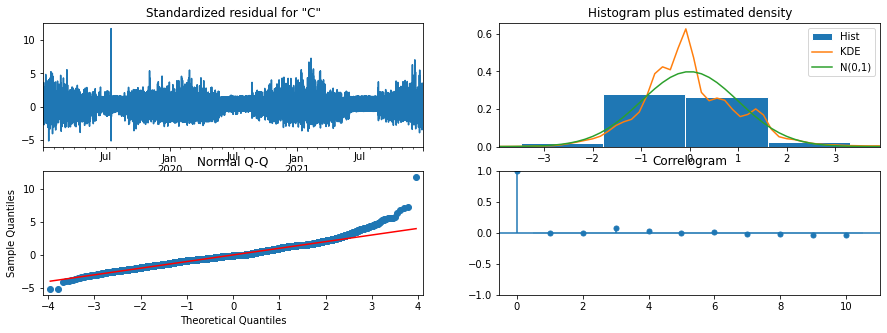

In [41]:
# Plot diagnostics of best model
_ = m2.plot_diagnostics(figsize=(15, 5))

In [43]:
# Summary results
# This model has better diagnostics, the residuals (based on ljung-box statistic) are now independently distributed
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                            Consumption   No. Observations:                26302
Model:             SARIMAX(2, 0, 1)x(2, 1, [1, 2], 5)   Log Likelihood               33800.258
Date:                                Thu, 11 Aug 2022   AIC                         -67584.517
Time:                                        15:27:54   BIC                         -67519.099
Sample:                                    01-01-2019   HQIC                        -67563.394
                                         - 12-31-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6128      0.010     58.723      0.000       0.592       0.633
ar.L2          0.3048      0.009     34.763      0.000       0.288       0.322
ma.L1         -0.2918      0.010    -29.019      0.000      -0.311      -0.272
ar.S.L5       -0.4426      0.078     -5.654      0.000      -0.596      -0.289
ar.S.L10      -0.0502      0.007     -7.443      0.000      -0.063      -0.037
ma.S.L5       -0.5310      0.079     -6.749      0.000      -0.685      -0.377
ma.S.L10      -0.4428      0.077     -5.719      0.000      -0.595      -0.291
sigma2         0.0045   2.85e-05    157.148      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   1.49   Jarque-Bera (JB):              7605.82
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.57
Prob(H) (two-sided):                  0.48   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Timeseries Decomposition
We try an alternative approach to decompose the series into seasonal, trend and residual components.
If these components can be extracted successfully, we can test the behaviour of the residual component

In [36]:
# After this decomposition process some values observations are lost (become NaN values)
# So those will need to be dropped when computing some statistics as shown below
decomposed = sm.tsa.seasonal_decompose(clean_data[12]['Consumption'][:'2021'], model='additive')

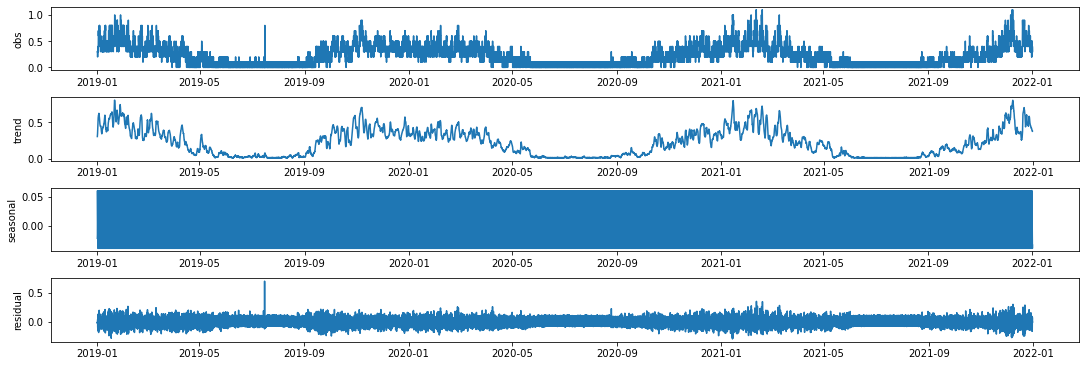

In [39]:
# Decomposing the series shows that the series has two levels of seasonanlity embedded
# A yearly cycle depicted by the (trend component) and daily seasonality shown by the (seasonality component)

fig, ax = plt.subplots(4, 1, figsize=(15,5))
_ = ax[0].plot(decomposed.observed)
ax[0].set_ylabel('obs')
_ = ax[1].plot(decomposed.trend)
ax[1].set_ylabel('trend')
_ = ax[2].plot(decomposed.seasonal)
ax[2].set_ylabel('seasonal')
_ = ax[3].plot(decomposed.resid)
ax[3].set_ylabel('residual')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

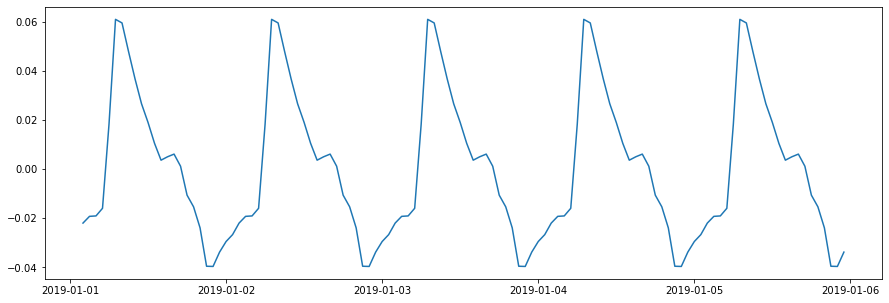

In [55]:
# Zooming the seasonal component 
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.plot(decomposed.seasonal['2019-01-01':'2019-01-05'])

In [56]:
decomposed.resid.isnull().all()

False

In [38]:
decomposed.resid['2019-01-01 12:00:00 ':]

2019-01-01 12:00:00         NaN
2019-01-01 13:00:00         NaN
2019-01-01 14:00:00   -0.005707
2019-01-01 15:00:00   -0.011256
2019-01-01 16:00:00   -0.014430
                         ...   
2021-12-31 19:00:00         NaN
2021-12-31 20:00:00         NaN
2021-12-31 21:00:00         NaN
2021-12-31 22:00:00         NaN
2021-12-31 23:00:00         NaN
Freq: H, Name: resid, Length: 26292, dtype: float64

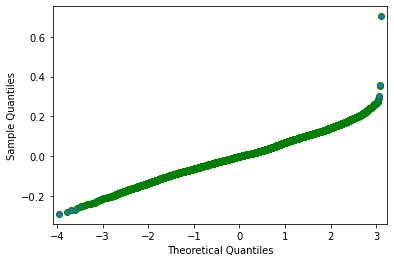

In [44]:
# much better and closer to the normal distribution despite some outliers
# we can use statistical test to confirm
_ = sm.qqplot(decomposed.resid, line='r', markeredgecolor='g', marker='o')

In [45]:
# Run statistical tests for normality of residuals
# Now we see that in the decomposed version the residuals can be considered random noise
# H_o: The data are independently distributed

acorr_ljungbox(decomposed.resid.dropna(), boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2185.067606,0.0,2184.818169,0.0
2,5977.237523,0.0,5976.410891,0.0
3,8013.469837,0.0,8012.255794,0.0
4,8817.591760,0.0,8816.194127,0.0
5,8946.281040,0.0,8944.849130,0.0
6,8961.214306,0.0,8959.777850,0.0
7,9393.364516,0.0,9391.780063,0.0
8,10544.492056,0.0,10542.469579,0.0
9,12550.923196,0.0,12548.060888,0.0
10,15627.877304,0.0,15623.609995,0.0


In [46]:
# Test for stationarity shows the residuals are stationary
# H_o: Timeseries are non-stationary
# H_a: Timeseries are stationary
st.adfuller(decomposed.resid.dropna())

(-33.9177555400551,
 0.0,
 49,
 26228,
 {'1%': -3.4305993495546176,
  '5%': -2.861650205181056,
  '10%': -2.5668286589560503},
 -79585.81268124862)

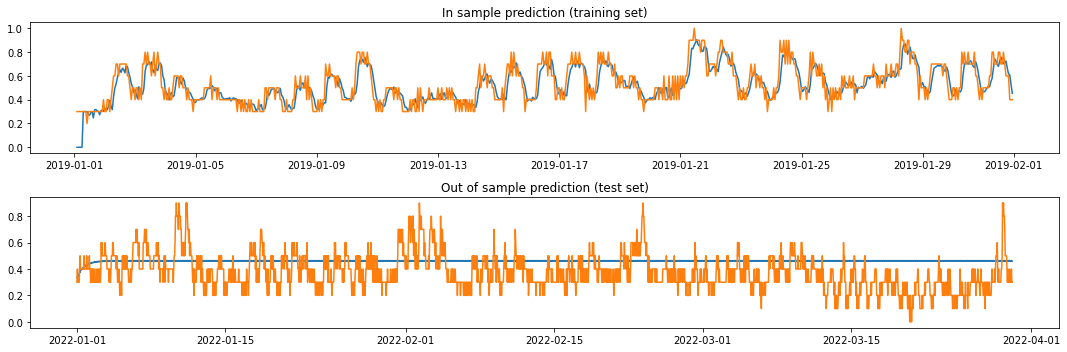

In [50]:
# plot forecast and true values of this model
# insample (training score)
# out-of sample (test score) 
# out-of sample shows model does not perform well with the test set
predicted = m2.predict() # change m1,m2
forecasted = m2.get_prediction(start='2022-01-01', end='2022-03-30 05:00:00') # out of sample
fig, ax = plt.subplots(2, 1, figsize=(15,5))
_ = ax[0].plot(predicted['2019-01'])
_ = ax[0].plot(clean_data[12]['Consumption']['2019-01'])
ax[0].set_title('In sample prediction (training set)')
_ = ax[1].plot(forecasted.predicted_mean)
_ = ax[1].plot(clean_data[12]['Consumption']['2022'])
ax[1].set_title('Out of sample prediction (test set)')
fig.tight_layout()

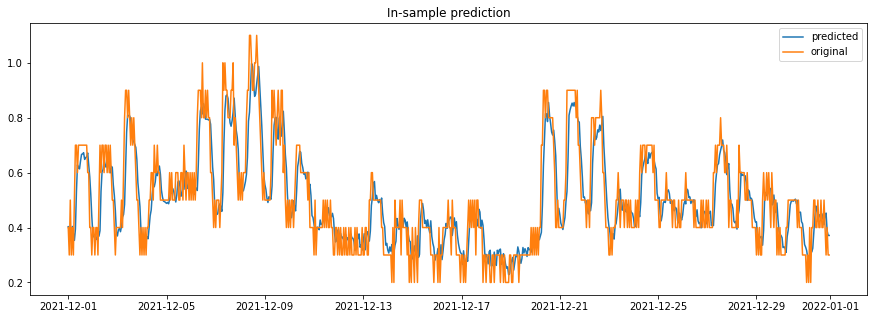

In [51]:
# Test the pdmarima model

# In-sample prediction 
# The model performs well in in-sample predictions
# Out of sample prediction is tested in the cell below

pred = m2.get_prediction(start='2021-12', end='2021-12-31')
pred_values = pred.predicted_mean

fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title('In-sample prediction')
_ = ax.plot(pred.predicted_mean, label='predicted')
_ = ax.plot(clean_data[12]['Consumption']['2021-12'], label='original')
_ = ax.legend()

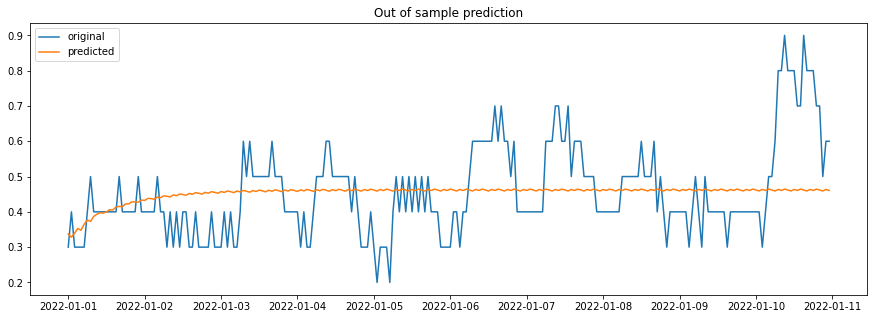

In [52]:
# Out of sample prediction
# Model performance degrades when forecasting longer time period
# graph below shows a forecast of 10 days

pred = m2.get_prediction(start='2022-01-01', end='2022-03-30 05:00:00')
#pred_values = pred.predicted_mean

fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title('Out of sample prediction')
_ = ax.plot(clean_data[12]['Consumption']['2022-01-01':'2022-01-10'], label='original')
_ = ax.plot(pred.predicted_mean[:'2022-01-10'], label='predicted')
_ = ax.legend()

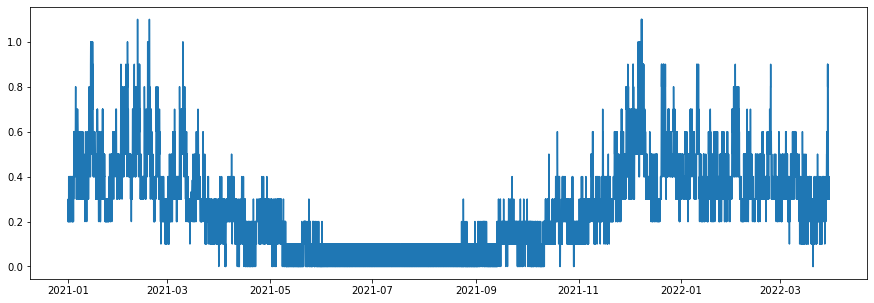

In [50]:
fig, ax = plt.subplots(figsize = (15, 5))

ax.plot(clean_data[12]['Consumption']['2021-01':])

In [ ]:
# smodel = pm.auto_arima(data, start_p=1, start_q=1,
#                          test='adf',
#                          max_p=3, max_q=3, m=12,
#                          start_P=0, seasonal=True,
#                          d=None, D=1, trace=True,
#                          error_action='ignore',  
#                          suppress_warnings=True, 
#                          stepwise=True)


empirical_model_2 = pmdarima.auto_arima(clean_data[12]['Consumption'][:'2021'],
                                      start_p=1, start_q=1,
                                      test='adf',
                                      max_p=7, max_q=7, m=12,
                                      start_P=0, seasonal=True,
                                      D=1, trace=True,
                                      error_action='ignore',  
                                      suppress_warnings=True, 
                                      stepwise=True)

### Multiple levels of seasonality
Here we use (MSTL) avilable in the new version of statsmodels (compiled from source)

In [30]:
# Challenge a large sample size of timeseries
# https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
# https://stackoverflow.com/questions/63438979/python-pmdarima-autoarima-does-not-work-with-large-data
# https://github.com/KishManani/MSTL/blob/main/mstl_decomposition.ipynb
# https://towardsdatascience.com/multi-seasonal-time-series-decomposition-using-mstl-in-python-136630e67530

In [74]:
mstl = MSTL(clean_data[12]['Consumption'][:'2021'], periods=(24, 24 * 7)) #24 * 7 * 52
mstl_res = mstl.fit()

In [75]:
mstl_res.seasonal

,seasonal_24,seasonal_168
2019-01-01 02:00:00,-0.016587,-0.046460
2019-01-01 03:00:00,-0.038727,-0.012842
2019-01-01 04:00:00,-0.050635,-0.045460
2019-01-01 05:00:00,-0.083450,0.014555
2019-01-01 06:00:00,0.027734,-0.001380
...,...,...
2021-12-31 19:00:00,0.023866,0.026215
2021-12-31 20:00:00,-0.077682,0.057747
2021-12-31 21:00:00,-0.008429,-0.000648
2021-12-31 22:00:00,-0.062904,0.000111


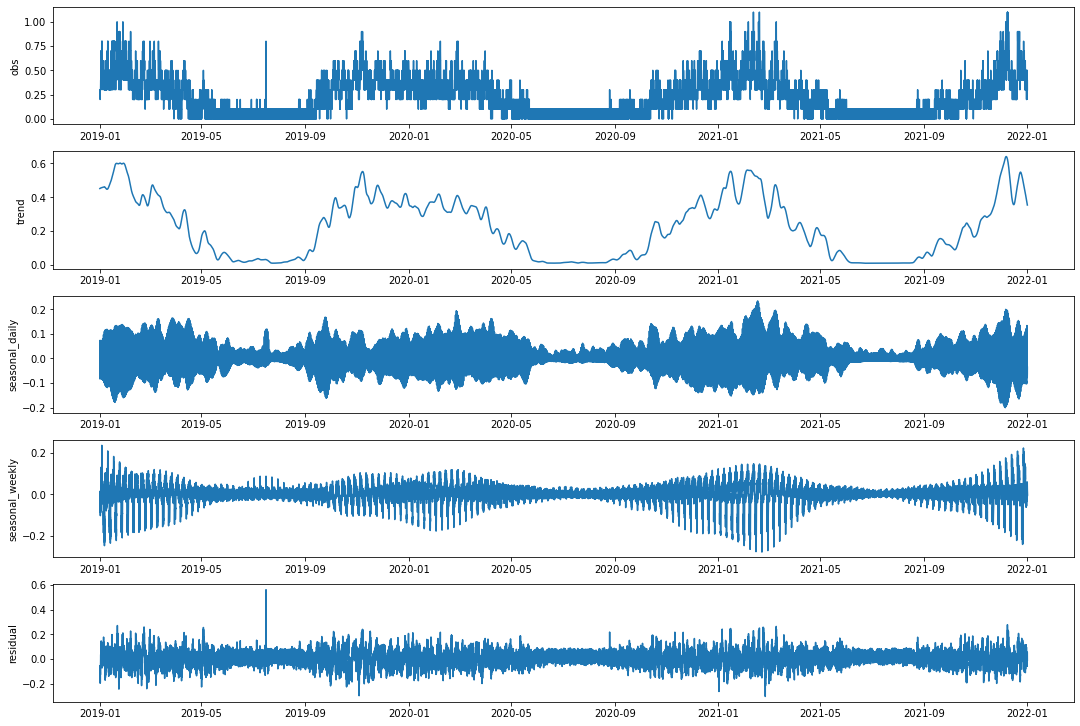

In [111]:
# The series are observed to have multiple levels of seasonality (Daily, weekly, yearly)

fig, ax = plt.subplots(5, 1, figsize=(15,10))
_ = ax[0].plot(mstl_res.observed)
ax[0].set_ylabel('obs')
_ = ax[1].plot(mstl_res.trend)
ax[1].set_ylabel('trend')
_ = ax[2].plot(mstl_res.seasonal.seasonal_24)
ax[2].set_ylabel('seasonal_daily')

_ = ax[3].plot(mstl_res.seasonal.seasonal_168)
ax[3].set_ylabel('seasonal_weekly')

_ = ax[4].plot(mstl_res.resid)
ax[4].set_ylabel('residual')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [108]:
# The residuals are independently distributed after adjusting for various seasonality components
acorr_ljungbox(mstl_res.resid, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,4167.970287,0.0,4167.494925,0.0
2,12009.258390,0.0,12007.590619,0.0
3,19274.276141,0.0,19271.227397,0.0
4,25790.969557,0.0,25786.434341,0.0
5,31743.215042,0.0,31737.095820,0.0
6,37276.963673,0.0,37269.161437,0.0
7,41986.189613,0.0,41976.776100,0.0
8,46348.961472,0.0,46337.889363,0.0
9,50399.000645,0.0,50386.234861,0.0
10,53939.300715,0.0,53924.919830,0.0


In [109]:
# residuals are stationary (Null hypothesis: non-stationarity)
st.adfuller(mstl_res.resid)

(-26.81900221059312,
 0.0,
 49,
 26252,
 {'1%': -3.4305991215729548,
  '5%': -2.861650104424084,
  '10%': -2.5668286053253606},
 -93762.03359586472)

## Energy consumption & Temperature
 Test models that makes use of temperature to predict energy consumption

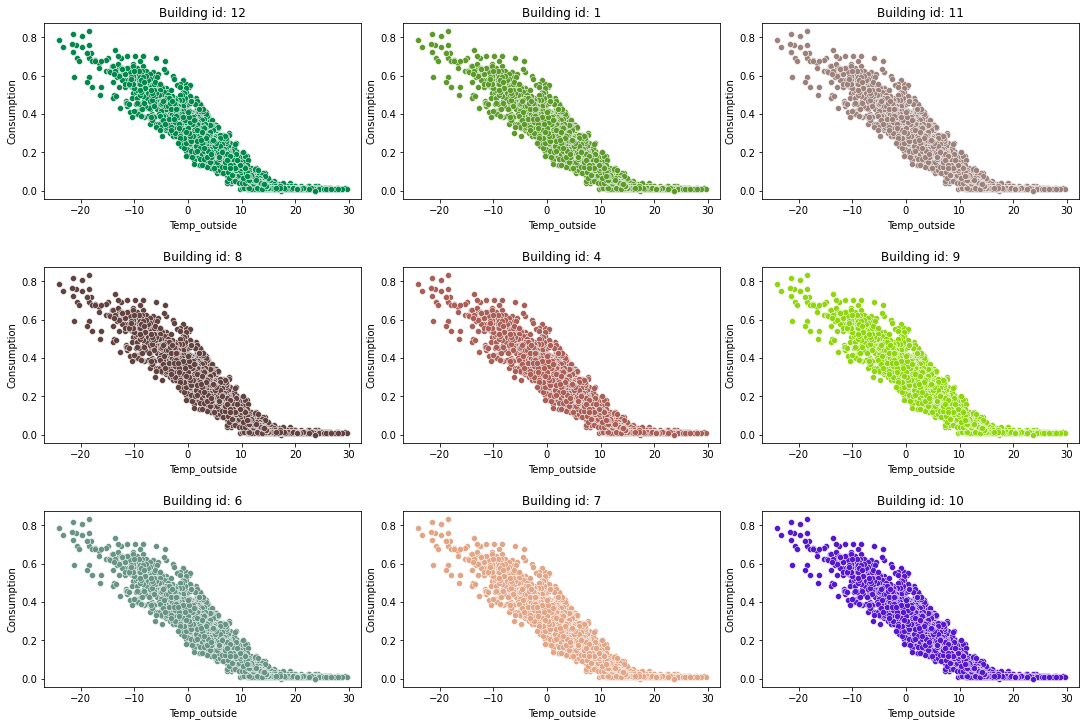

In [51]:
# Plot correlation between energy and temperature across all buildings
# Energy consumption has a negative correlation with outdoors temperature (as expected)

fig, ax = plt.subplots(3,3, figsize=(15,10))
buildings = list(masks.keys())
for r in range(3):
    for c in range(3):
        building = buildings.pop()
        daily_avg = clean_data[building].resample('12H').mean()
        _ = sns.scatterplot(x='Temp_outside', y='Consumption', ax=ax[r][c], color=np.random.rand(3), data=daily_avg)
        ax[r][c].set_title(f'Building id: {building}')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

In [49]:
energy_temp_model = pmdarima.auto_arima(clean_data[12]['Consumption'][:'2021'],
                                        clean_data[12]['Temp_outside'][:'2021'].values.reshape(-1, 1),
                                        start_p=1, start_q=1,
                                        max_p=7, max_q=7, d=1, m=5,
                                        start_P=0, seasonal=True,
                                        D=1, trace=True,
                                        error_action='ignore',
                                        suppress_warnings=True,
                                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=78.25 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-38770.568, Time=9.25 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-54553.346, Time=38.87 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=99.08 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-47856.425, Time=5.02 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-57752.853, Time=101.96 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=110.68 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=69.66 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=-49402.789, Time=8.43 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=-58610.062, Time=68.69 sec
 ARIMA(2,1,0)(1,1,0)[5]             : AIC=-55448.996, Time=47.29 sec
 ARIMA(2,1,0)(2,1,1)[5]             : AIC=inf, Time=126.91 sec
 ARIMA(2,1,0)(1,1,1)[5]             : AIC=inf, Time=87.84 sec
 ARIMA(3,1,0)(2,1,0)[5]             : AIC=-58616.933, Time=98.86 sec
 ARIMA(3,1,0)(1,1,0)[5]          

In [50]:
energy_temp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                26302
Model:             SARIMAX(4, 1, 2)x(2, 1, [1], 5)   Log Likelihood               33277.477
Date:                             Sat, 13 Aug 2022   AIC                         -66532.953
Time:                                     00:05:40   BIC                         -66443.005
Sample:                                          0   HQIC                        -66503.910
                                           - 26302                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0068      0.000    -23.063      0.000      -0.007      -0.006
ar.L1         -1.9010      0.068    -28.062      0.000      -2.034      -1.768
ar.L2         -1.6219      0.102    -15.934      0.000      -1.821      -1.422
ar.L3         -0.6510      0.050    -12.902      0.000      -0.750      -0.552
ar.L4         -0.1518      0.010    -14.622      0.000      -0.172      -0.131
ma.L1          1.2535      0.068     18.545      0.000       1.121       1.386
ma.L2          0.6131      0.060     10.174      0.000       0.495       0.731
ar.S.L5       -0.1188      0.009    -13.160      0.000      -0.136      -0.101
ar.S.L10      -0.1430      0.006    -22.624      0.000      -0.155      -0.131
ma.S.L5       -0.9199      0.004   -247.918      0.000      -0.927      -0.913
sigma2         0.0048   3.29e-05    145.827      0.000       0.005       0.005
===================================================================================
Ljung-Box (L1) (Q):                  35.37   Jarque-Bera (JB):              5645.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.46
Prob(H) (two-sided):                  0.22   Kurtosis:                         5.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
d12 = clean_data[12]#clean_data[12]['Consumption'][:'2021']
d12 = d12.resample('W').mean()
d12 = d12.join(d12['Temp_outside'].shift(periods=1), rsuffix='1').\
join(d12['Temp_outside'].shift(periods=2), rsuffix='2').\
join(d12['Temp_outside'].shift(periods=3), rsuffix='3').\
join(d12['Temp_outside'].shift(periods=4), rsuffix='4').\
join(d12['Temp_outside'].shift(periods=7), rsuffix='7')

In [106]:
d12.head(10)

,Consumption,Temp_outside,Temp_outside1,Temp_outside2,Temp_outside3,Temp_outside4,Temp_outside7
2019-01-06,0.460563,-4.519718,NaN,NaN,NaN,NaN,NaN
2019-01-13,0.445238,-3.251786,-4.519718,NaN,NaN,NaN,NaN
2019-01-20,0.544048,-8.714881,-3.251786,-4.519718,NaN,NaN,NaN
2019-01-27,0.610119,-12.526786,-8.714881,-3.251786,-4.519718,NaN,NaN
2019-02-03,0.578571,-8.951190,-12.526786,-8.714881,-3.251786,-4.519718,NaN
2019-02-10,0.436310,-2.101786,-8.951190,-12.526786,-8.714881,-3.251786,NaN
2019-02-17,0.365476,0.483929,-2.101786,-8.951190,-12.526786,-8.714881,NaN
2019-02-24,0.413095,-2.191667,0.483929,-2.101786,-8.951190,-12.526786,-4.519718
2019-03-03,0.375000,-1.079167,-2.191667,0.483929,-2.101786,-8.951190,-3.251786
2019-03-10,0.438095,-4.098214,-1.079167,-2.191667,0.483929,-2.101786,-8.714881


In [107]:
d12.dropna(inplace=True)
y = d12['Consumption']
x = d12[['Temp_outside', 'Temp_outside1', 'Temp_outside2',
         'Temp_outside3', 'Temp_outside4','Temp_outside7']]
regr_model_1 = sm.OLS(y,x).fit()

In [108]:
regr_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Consumption   R-squared (uncentered):                   0.080
Model:                            OLS   Adj. R-squared (uncentered):              0.045
Method:                 Least Squares   F-statistic:                              2.285
Date:                Mon, 15 Aug 2022   Prob (F-statistic):                      0.0384
Time:                        06:51:10   Log-Likelihood:                         -14.498
No. Observations:                 163   AIC:                                      41.00
Df Residuals:                     157   BIC:                                      59.56
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Temp_outside     -0.0080      0.006     -1.288      0.200      -0.020       0.004
Temp_outside1     0.0031      0.007      0.431      0.667      -0.011       0.017
Temp_outside2     0.0015      0.007      0.215      0.830      -0.013       0.016
Temp_outside3    -0.0022      0.007     -0.298      0.766      -0.017       0.012
Temp_outside4    -0.0039      0.007     -0.585      0.560      -0.017       0.009
Temp_outside7     0.0125      0.005      2.699      0.008       0.003       0.022
==============================================================================
Omnibus:                       60.656   Durbin-Watson:                   0.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.393
Skew:                          -0.015   Prob(JB):                      0.00913
Kurtosis:                       1.824   Cond. No.                         10.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

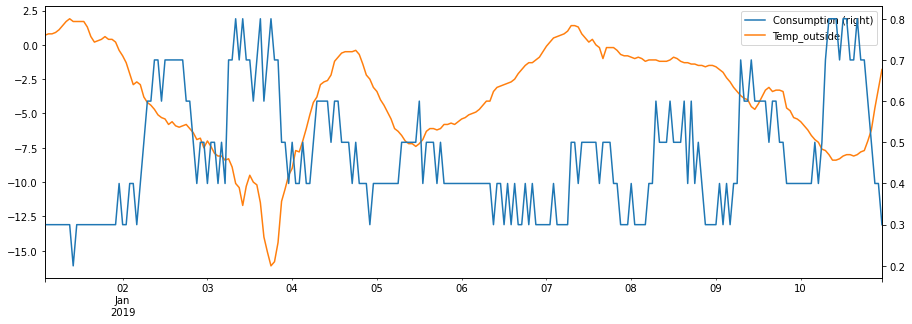

In [66]:
clean_data[12].loc['2019-01-01':'2019-01-10'].plot(secondary_y=['Consumption'], figsize=(15,5))

In [120]:
#d12_resampled = clean_data[12].resample('W').mean()
regr_model_2 = sm.OLS(clean_data[12]['Consumption'].resample('W').sum(),
                      clean_data[12]['Temp_outside'].resample('W').mean()).fit()

<AxesSubplot:>

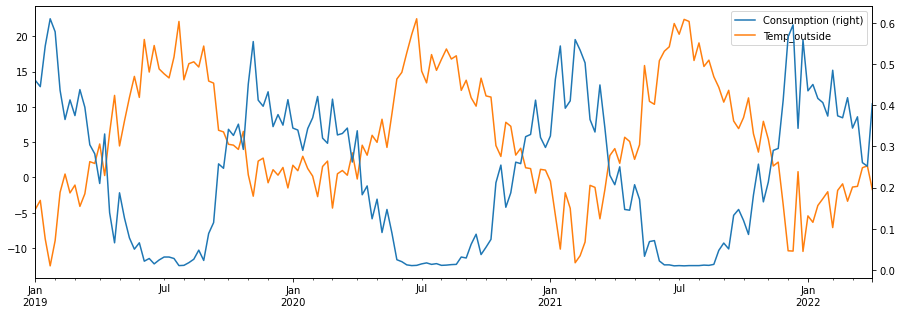

In [121]:
#d12_resampled.loc['2019-01-01':'2019-01-10'].plot(secondary_y=['Consumption'], figsize=(15,5))
d12_resampled.plot(secondary_y=['Consumption'], figsize=(15,5))

In [122]:
regr_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Consumption   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.004
Method:                 Least Squares   F-statistic:                             0.3561
Date:                Mon, 15 Aug 2022   Prob (F-statistic):                       0.551
Time:                        07:50:59   Log-Likelihood:                         -899.45
No. Observations:                 170   AIC:                                      1801.
Df Residuals:                     169   BIC:                                      1804.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Temp_outside    -0.2176      0.365     -0.597      0.551      -0.938       0.502
==============================================================================
Omnibus:                       64.317   Durbin-Watson:                   0.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.311
Skew:                           0.238   Prob(JB):                      0.00350
Kurtosis:                       1.830   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

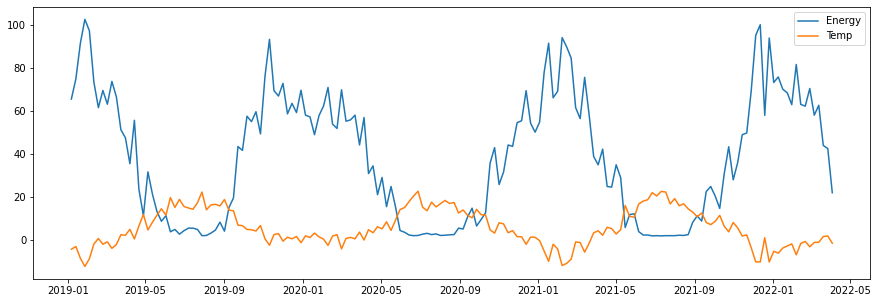

In [123]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(clean_data[12]['Consumption'].resample('W').sum(), label='Energy')
ax.plot(clean_data[12]['Temp_outside'].resample('W').mean(), label='Temp')
ax.legend()

In [127]:
pd.DataFrame({'Engergy': clean_data[12]['Consumption'].resample('W').sum(),
              'Temp_outdoor': clean_data[12]['Temp_outside'].resample('W').mean()}).corr()

,Engergy,Temp_outdoor
Engergy,1.000000,-0.953513
Temp_outdoor,-0.953513,1.000000


In [76]:
from tsfresh import select_features, extract_features

In [95]:
data = clean_data[12]
data['id'] = clean_data[12].index

X = extract_features(data, column_id='id')

Feature Extraction: 100%|██████████| 20/20 [17:00<00:00, 51.03s/it]


In [96]:
X

,Consumption__variance_larger_than_standard_deviation,Consumption__has_duplicate_max,Consumption__has_duplicate_min,Consumption__has_duplicate,Consumption__sum_values,Consumption__abs_energy,Consumption__mean_abs_change,Consumption__mean_change,Consumption__mean_second_derivative_central,Consumption__median,...,Temp_outside__permutation_entropy__dimension_5__tau_1,Temp_outside__permutation_entropy__dimension_6__tau_1,Temp_outside__permutation_entropy__dimension_7__tau_1,Temp_outside__query_similarity_count__query_None__threshold_0.0,"Temp_outside__matrix_profile__feature_""min""__threshold_0.98","Temp_outside__matrix_profile__feature_""max""__threshold_0.98","Temp_outside__matrix_profile__feature_""mean""__threshold_0.98","Temp_outside__matrix_profile__feature_""median""__threshold_0.98","Temp_outside__matrix_profile__feature_""25""__threshold_0.98","Temp_outside__matrix_profile__feature_""75""__threshold_0.98"
2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.3,0.09,NaN,NaN,NaN,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.3,0.09,NaN,NaN,NaN,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.3,0.09,NaN,NaN,NaN,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 05:00:00,0.0,0.0,0.0,0.0,0.3,0.09,NaN,NaN,NaN,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 06:00:00,0.0,0.0,0.0,0.0,0.3,0.09,NaN,NaN,NaN,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-30 01:00:00,0.0,0.0,0.0,0.0,0.3,0.09,NaN,NaN,NaN,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-30 02:00:00,0.0,0.0,0.0,0.0,0.3,0.09,NaN,NaN,NaN,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-30 03:00:00,0.0,0.0,0.0,0.0,0.4,0.16,NaN,NaN,NaN,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-30 04:00:00,0.0,0.0,0.0,0.0,0.3,0.09,NaN,NaN,NaN,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
sum(X['Consumption__variance_larger_than_standard_deviation'].values)

0.0

In [100]:
clean_data[12]['Consumption']>clean_data[12]['Consumption'].std()

0.19921158141199938

In [101]:
clean_data[12]['Consumption']

2019-01-01 02:00:00    0.3
2019-01-01 03:00:00    0.3
2019-01-01 04:00:00    0.3
2019-01-01 05:00:00    0.3
2019-01-01 06:00:00    0.3
                      ... 
2022-03-30 01:00:00    0.3
2022-03-30 02:00:00    0.3
2022-03-30 03:00:00    0.4
2022-03-30 04:00:00    0.3
2022-03-30 05:00:00    0.3
Freq: H, Name: Consumption, Length: 28420, dtype: float64

## Modelling using ARCH/GARCH Models

In [5]:
# ToDo: Test ARCH and GARCH Models on this data. We test these models in the hope that they might capture
# the seasonality in the data in more robust way as opposed to ARIMA models above
# https://www.youtube.com/watch?v=inoBpq1UEn4
# https://www.youtube.com/watch?v=Li95a2biFCU&list=RDCMUCUcpVoi5KkJmnE3bvEhHR0Q&index=2

## Modelling using Prophet

In [4]:
# ToDo: Test the Prophet model as an alternative modelling approach. Prophet uses alternative approaches to 
# model the underlying timeseries aspects such as seasonality etc.
# https://facebook.github.io/prophet/docs/quick_start.html#python-api